#Подключаем библиотеки и загружаем данные

In [0]:
from sklearn import ensemble, model_selection, datasets, metrics, tree, linear_model, preprocessing 
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Данные по заражениям

In [0]:
!git clone https://github.com/CSSEGISandData/COVID-19.git

Cloning into 'COVID-19'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 18172 (delta 5), reused 10 (delta 5), pack-reused 18158
Receiving objects: 100% (18172/18172), 71.71 MiB | 10.76 MiB/s, done.
Resolving deltas: 100% (9240/9240), done.


## Данные про страны

In [0]:
!git clone https://github.com/vlomme/sberbank-covid19-forecast-2020.git

Cloning into 'sberbank-covid19-forecast-2020'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 51 (delta 19), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (51/51), done.


## Данные по карантинам

In [0]:
!git clone https://github.com/tyz910/sberbank-covid19.git

Cloning into 'sberbank-covid19'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 33 (delta 9), reused 31 (delta 7), pack-reused 0
Unpacking objects: 100% (33/33), done.


## Загружаем данные

In [0]:
test = pd.read_csv("/content/test.csv")
train = pd.read_csv("/content/train.csv")
test = test[test.Date > "2020-04-05"]
all_data = pd.concat([train, test],ignore_index=True).sort_values(by=['Country_Region', 'Date'])
all_data['ConfirmedCases'] = all_data['ConfirmedCases'].fillna(-1)
all_data['Fatalities'] = all_data['Fatalities'].fillna(-1)
countries = pd.read_csv("/content/sberbank-covid19-forecast-2020/countries.csv")
countries.drop(['iso_alpha3','iso_numeric','official_name','name','iso_alpha2'], axis='columns',inplace=True)
#Карантин
data_quarantine = pd.read_csv("/content/sberbank-covid19/data/quarantine_dates.csv")
data_quarantine = data_quarantine.groupby("Country").max().loc[:,"Start date"]
data_quarantine.loc["Russia"] = "2020-03-30"
countries = countries.set_index("ccse_name", drop=True)
countries["Quarantine"] = data_quarantine
#countries = countries.rename(columns={"ccse_name": "countries"})
countries_mean = countries.mean()
all_data = all_data.merge(countries, how ="left" , left_on="Country_Region", right_on='ccse_name')
all_data['fertility_rate'] = all_data['fertility_rate'].fillna(countries_mean['fertility_rate'])
all_data['median_age'] = all_data['median_age'].fillna(countries_mean['median_age'])
all_data['migrants'] = all_data['migrants'].fillna(countries_mean['migrants'])
all_data['urban_pop_rate'] = all_data['urban_pop_rate'].fillna(countries_mean['urban_pop_rate'])
all_data['density'] = all_data['density'].fillna(countries_mean['density'])
all_data['land_area'] = all_data['land_area'].fillna(countries_mean['land_area'])
all_data['population'] = all_data['population'].fillna(countries_mean['population'])
all_data['world_share'] = all_data['world_share'].fillna(countries_mean['world_share'])
all_data['Quarantine'] = all_data['Quarantine'].fillna("2020-04-30")

all_data.drop(['Id'], axis='columns',inplace=True)
all_data['Province_State'] = all_data['Province_State'].fillna(0)

In [0]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32742 entries, 0 to 32741
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province_State  32742 non-null  object 
 1   Country_Region  32742 non-null  object 
 2   Date            32742 non-null  object 
 3   ConfirmedCases  32742 non-null  float64
 4   Fatalities      32742 non-null  float64
 5   ForecastId      9792 non-null   float64
 6   density         32742 non-null  float64
 7   fertility_rate  32742 non-null  float64
 8   land_area       32742 non-null  float64
 9   median_age      32742 non-null  float64
 10  migrants        32742 non-null  float64
 11  population      32742 non-null  float64
 12  urban_pop_rate  32742 non-null  float64
 13  world_share     32742 non-null  float64
 14  Quarantine      32742 non-null  object 
dtypes: float64(11), object(4)
memory usage: 4.0+ MB


# Обрабатываем данные

## Добавляем признак, количество дней от первого зараженного

In [0]:
data2 = all_data

#Удалим дни без больных
data2 = data2[data2.ConfirmedCases != 0]
# Считаем дни от первого больного
data2["Date"] = pd.to_datetime(data2.Date)
#data2 = data2[(data2["Date"]<pd.to_datetime("2020-05-1")) & ((data2["Date"]>pd.to_datetime("2020-04-1")) | (data2.ConfirmedCases !=-1))]
data4 = data2[["Country_Region","Date"]].groupby("Country_Region").min()
data4.columns = ["Date_min"]
data2 = data2.merge(data4, how = 'left', left_on='Country_Region', right_on='Country_Region')
data2["days"] = (data2.Date - data2.Date_min).dt.days
data2["days_mart"] = (data2.Date - pd.to_datetime("2020-03-1")).dt.days
data2["days_after_Quarantine"] = (data2.Date - pd.to_datetime(data2.Quarantine)).dt.days
data2.drop(['Date_min'], axis='columns',inplace=True)
data2.Date = data2["Date"].apply(lambda x: pd.Series(x.strftime("%m-%d")))
data2 = data2.rename(columns={"ConfirmedCases": "confirmed","Fatalities":"deaths","Country_Region":"countries"})
data2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Province_State,countries,Date,confirmed,deaths,ForecastId,density,fertility_rate,land_area,median_age,migrants,population,urban_pop_rate,world_share,Quarantine,days,days_mart,days_after_Quarantine
0,0,Afghanistan,02-24,1.0,0.0,NaN,60.0,4.6,652860.0,18.0,-62920.0,38928346.0,0.25,0.0050,2020-04-30,0,-6,-66
1,0,Afghanistan,02-25,1.0,0.0,NaN,60.0,4.6,652860.0,18.0,-62920.0,38928346.0,0.25,0.0050,2020-04-30,1,-5,-65
2,0,Afghanistan,02-26,1.0,0.0,NaN,60.0,4.6,652860.0,18.0,-62920.0,38928346.0,0.25,0.0050,2020-04-30,2,-4,-64
3,0,Afghanistan,02-27,1.0,0.0,NaN,60.0,4.6,652860.0,18.0,-62920.0,38928346.0,0.25,0.0050,2020-04-30,3,-3,-63
4,0,Afghanistan,02-28,1.0,0.0,NaN,60.0,4.6,652860.0,18.0,-62920.0,38928346.0,0.25,0.0050,2020-04-30,4,-2,-62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20772,0,Zimbabwe,05-03,-1.0,-1.0,13154.0,38.0,3.6,386850.0,19.0,-116858.0,14862924.0,0.38,0.0019,2020-03-30,44,63,34
20773,0,Zimbabwe,05-04,-1.0,-1.0,13155.0,38.0,3.6,386850.0,19.0,-116858.0,14862924.0,0.38,0.0019,2020-03-30,45,64,35
20774,0,Zimbabwe,05-05,-1.0,-1.0,13156.0,38.0,3.6,386850.0,19.0,-116858.0,14862924.0,0.38,0.0019,2020-03-30,46,65,36
20775,0,Zimbabwe,05-06,-1.0,-1.0,13157.0,38.0,3.6,386850.0,19.0,-116858.0,14862924.0,0.38,0.0019,2020-03-30,47,66,37


## Добавить данные за прошлый день

In [0]:
old_con = data2["confirmed"].iloc[:-1]
old_con2 = data2["deaths"].iloc[:-1]
data2 = data2.iloc[1:]
data2["pred_conf"] = old_con.values
data2["pred_deaths"] = old_con2.values
data2 = data2.iloc[1:]
data2["delta_conf1"] = old_con.values[1:] - old_con.values[:-1]
data2["delta_deaths1"] = old_con2.values[1:] - old_con2.values[:-1]
data2 = data2.iloc[1:]
data2["delta_conf2"] = old_con.values[2:] - old_con.values[:-2]
data2["delta_deaths2"] = old_con2.values[2:] - old_con2.values[:-2]
data2[data2.countries == "Russia"].iloc[0:70]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Province_State,countries,Date,confirmed,deaths,ForecastId,density,fertility_rate,land_area,median_age,migrants,population,urban_pop_rate,world_share,Quarantine,days,days_mart,days_after_Quarantine,pred_conf,pred_deaths,delta_conf1,delta_deaths1,delta_conf2,delta_deaths2
14342,0,Russia,01-31,2.0,0.0,NaN,9.0,1.8,16376870.0,40.0,182456.0,145934462.0,0.74,0.0187,2020-03-30,0,-30,-59,-1.0,-1.0,0.0,0.0,0.0,0.0
14343,0,Russia,02-01,2.0,0.0,NaN,9.0,1.8,16376870.0,40.0,182456.0,145934462.0,0.74,0.0187,2020-03-30,1,-29,-58,2.0,0.0,3.0,1.0,3.0,1.0
14344,0,Russia,02-02,2.0,0.0,NaN,9.0,1.8,16376870.0,40.0,182456.0,145934462.0,0.74,0.0187,2020-03-30,2,-28,-57,2.0,0.0,0.0,0.0,3.0,1.0
14345,0,Russia,02-03,2.0,0.0,NaN,9.0,1.8,16376870.0,40.0,182456.0,145934462.0,0.74,0.0187,2020-03-30,3,-27,-56,2.0,0.0,0.0,0.0,0.0,0.0
14346,0,Russia,02-04,2.0,0.0,NaN,9.0,1.8,16376870.0,40.0,182456.0,145934462.0,0.74,0.0187,2020-03-30,4,-26,-55,2.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14407,0,Russia,04-05,5389.0,45.0,NaN,9.0,1.8,16376870.0,40.0,182456.0,145934462.0,0.74,0.0187,2020-03-30,65,35,6,4731.0,43.0,582.0,9.0,1183.0,13.0
14408,0,Russia,04-06,-1.0,-1.0,8655.0,9.0,1.8,16376870.0,40.0,182456.0,145934462.0,0.74,0.0187,2020-03-30,66,36,7,5389.0,45.0,658.0,2.0,1240.0,11.0
14409,0,Russia,04-07,-1.0,-1.0,8656.0,9.0,1.8,16376870.0,40.0,182456.0,145934462.0,0.74,0.0187,2020-03-30,67,37,8,-1.0,-1.0,-5390.0,-46.0,-4732.0,-44.0
14410,0,Russia,04-08,-1.0,-1.0,8657.0,9.0,1.8,16376870.0,40.0,182456.0,145934462.0,0.74,0.0187,2020-03-30,68,38,9,-1.0,-1.0,0.0,0.0,-5390.0,-46.0


# Отделяем данные на трейн и тест

In [184]:
#Выберите день начала приватных данных начиная с 1 марта
days_x = 36
#model_Confirmed, model_Death = {}, {}

log_labels = False

#Удаляем ненужные фичи
#data3 = data2.drop(['Quarantine','world_share','urban_pop_rate','population', 'migrants','median_age','land_area','fertility_rate','density','delta_deaths2','delta_deaths1','pred_deaths','date','Date_min'], axis='columns')
data3 = data2.drop(['Quarantine','world_share', 'migrants','median_age','land_area','fertility_rate','density','Date'], axis='columns')
#data3 = data2.drop(['Quarantine','delta_deaths2','delta_deaths1','pred_deaths','date','Date_min'], axis='columns')
data3.population = data3.population/10**6

#Представляем штат в one_hot
one_hot = pd.get_dummies(data3['Province_State'])
data3 = data3.join(one_hot)


#Отделяем пару стран на тест
data_Korea = data3[(data3.countries == 'Korea, South') & (data3.confirmed > 0)]
data_Russia = data3[(data3.countries == 'Russia') & (data3.confirmed > 0)]

#Приватные данные
new_data = data3[data2.days_mart >= days_x]
old_data = data3[data2.days_mart < days_x]
old_data = old_data[(old_data.countries != 'Russia')&(old_data.countries != 'Korea, South')]

#Логорифмируем предсказания
#old_data["confirmed"] = log(old_data.confirmed) 

#Убираем ответ из данных
train_labels = old_data.confirmed
train_death = old_data.deaths
train_data = old_data.drop(['Province_State', 'ForecastId','confirmed','countries','deaths'], axis='columns')
train_data

,population,urban_pop_rate,days,days_mart,days_after_Quarantine,pred_conf,pred_deaths,delta_conf1,delta_deaths1,delta_conf2,delta_deaths2,0,Alabama,Alaska,Alberta,Anguilla,Anhui,Arizona,Arkansas,Aruba,Australian Capital Territory,Beijing,Bermuda,British Columbia,British Virgin Islands,California,Cayman Islands,Channel Islands,Chongqing,Colorado,Connecticut,Curacao,Delaware,District of Columbia,Faroe Islands,Florida,French Guiana,French Polynesia,Fujian,Gansu,...,Pennsylvania,Prince Edward Island,Puerto Rico,Qinghai,Quebec,Queensland,Reunion,Rhode Island,Saint Barthelemy,Saskatchewan,Shaanxi,Shandong,Shanghai,Shanxi,Sichuan,Sint Maarten,South Australia,South Carolina,South Dakota,St Martin,Tasmania,Tennessee,Texas,Tianjin,Tibet,Turks and Caicos Islands,Utah,Vermont,Victoria,Virgin Islands,Virginia,Washington,West Virginia,Western Australia,Wisconsin,Wyoming,Xinjiang,Yukon,Yunnan,Zhejiang
3,38.928346,0.25,3,-3,-63,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,38.928346,0.25,4,-2,-62,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,38.928346,0.25,5,-1,-61,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,38.928346,0.25,6,0,-60,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,38.928346,0.25,7,1,-59,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20740,14.862924,0.38,12,31,2,8.0,1.0,1.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20741,14.862924,0.38,13,32,3,8.0,1.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20742,14.862924,0.38,14,33,4,9.0,1.0,1.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20743,14.862924,0.38,15,34,5,9.0,1.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Предсказываем и строим графики

## Логорифмируем ли предсказания?

In [0]:
log_labels = True
train_labels = np.log10(train_labels+1)
train_death = np.log10(train_death+1)

## Функция. Строим график и считаем MALE ошибку

In [0]:
def pred_score(models, data, death = False, plot = 0):
  predictions_all = 0
  plt.rcParams['figure.figsize'] = [20, len(models)*10]
  data = data[(data.confirmed > 0)]
  death_labels  = data.deaths
  labels = data.confirmed
  data = data.drop(['ForecastId','confirmed','countries','deaths'], axis='columns')  
  for i, model in enumerate(models):
    if model == "reg":
      predictions = models[model].predict(scaler.transform(data))
    else:
      predictions = models[model].predict(data)
    if log_labels:
      predictions = 10**predictions - 1
    predictions_all = predictions_all + predictions
    if death:
      print("Ошибка MALE по смертям", model, np.sum(np.abs(np.log10((predictions+1)/(death_labels+1)))))
    else:
      print("Ошибка MALE по заражениям", model, np.sum(np.abs(np.log10((predictions+1)/(labels+1)))))
    if plot:
      plt.subplot(len(models), 1, i+1)
      if plot==1:
        plt.plot(predictions, label = "Предсказанное значение") 
        if death:
          plt.plot(death_labels.values, label = "Истинное значение")
          plt.gca().set(xlabel='Дни от случая первого заражения', ylabel='Смерти')
        else:
          plt.plot(labels.values, label = "Истинное значение")  
          plt.gca().set(xlabel='Дни от случая первого заражения', ylabel='Заражения')
      if plot==2:
        plt.scatter(np.arange(0,len(predictions),1), predictions, s = 1, label = "Предсказанное значение") 
        if death:
          plt.scatter(np.arange(0,len(predictions),1), death_labels.values, s = 1,  label = "Истинное значение")
          plt.gca().set(xlabel='Дни от случая первого заражения', ylabel='Смерти')
        else:
          plt.scatter(np.arange(0,len(predictions),1), labels.values, s = 1,  label = "Истинное значение")  
          plt.gca().set(xlabel='Дни от случая первого заражения', ylabel='Заражения')      
      plt.title(model)
      plt.grid(True)
      plt.legend() 
  predictions_all = predictions_all/len(models)
  if death:
    print("Ошибка MALE по смертям средняя", np.sum(np.abs(np.log10((predictions_all+1)/(death_labels+1)))))
  else:
    print("Ошибка MALE по заражениям средняя", np.sum(np.abs(np.log10((predictions_all+1)/(labels+1)))))      

# Модели

## Исправить! Обучаем Линейная регрессия

In [0]:
"""
# Масштабируем данные?
scaler_data = True
train_data_scaler = train_data
if scaler_data:
  scaler = preprocessing.StandardScaler()
  scaler.fit(train_data)
  train_data_scaler = scaler.transform(train_data)

model_Confirmed["Ridge"] = linear_model.Ridge().fit(train_data_scaler, train_labels)
model_Death["Ridge"] = linear_model.Ridge().fit(train_data_scaler, train_death)
"""

'\n# Масштабируем данные?\nscaler_data = True\ntrain_data_scaler = train_data\nif scaler_data:\n  scaler = preprocessing.StandardScaler()\n  scaler.fit(train_data)\n  train_data_scaler = scaler.transform(train_data)\n\nmodel_Confirmed["Ridge"] = linear_model.Ridge().fit(train_data_scaler, train_labels)\nmodel_Death["Ridge"] = linear_model.Ridge().fit(train_data_scaler, train_death)\n'

## Обучаем Adaboost Regressor

In [0]:
treeDepth = 10
mdl = tree.DecisionTreeRegressor(max_depth=treeDepth)
param_grid = {
    'n_estimators': [100, 250, 500],
    'learning_rate': [0.1, 0.01, 0.001]
                }
regrMdl = ensemble.AdaBoostRegressor(base_estimator=mdl)
model_Confirmed["Adaboost"] = model_selection.RandomizedSearchCV(estimator = regrMdl, param_distributions = param_grid, n_iter = 100, 
                                         cv = 3, verbose=0, random_state=42, n_jobs = -1).fit(train_data, train_labels)
model_Death["Adaboost"] = model_selection.RandomizedSearchCV(estimator = regrMdl, param_distributions = param_grid, n_iter = 100, 
                                         cv = 3, verbose=0, random_state=42, n_jobs = -1).fit(train_data, train_death)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 9 is smaller than n_iter=100. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 9 is smaller than n_iter=100. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


## Обучаем случайный лес

In [0]:
model_Confirmed["RandomForest"]  = ensemble.RandomForestRegressor(n_estimators=2000, max_depth=30).fit(train_data, train_labels)
model_Death["RandomForest"] = ensemble.RandomForestRegressor(n_estimators=2000, max_depth=30).fit(train_data, train_death)

## Обучаем xgboost

In [0]:
model_Confirmed["Xgboost"] = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=10000).fit(train_data, train_labels)
model_Death["Xgboost"] = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=10000).fit(train_data, train_death)

## Обучаем свою модель

In [0]:
#model_Confirmed["new"] = 
#model_Death["new"] = 

# Считаем ошибку строим графики

## Удаляем ненужные модели

In [0]:
#del model_Confirmed["Ridge"] 
#del model_Death["Ridge"] 

##Настройки

In [0]:
# Данные new_data - новые с дня Х, 
# data_Russia - Данные по России
# data_Korea  - Данные по Франции
data_pred = data_Korea 

# Тип графика 0 - без графика
# 1 - plot
# 2 - scatter
plot_type = 1

#Строим для заражений, или смертей
death_bool = False 
if death_bool:
  model = model_Death
else:
  model = model_Confirmed

## Строим

Ошибка MALE по заражениям Adaboost 4.790172703794941
Ошибка MALE по заражениям RandomForest 4.769317800902943
Ошибка MALE по заражениям Xgboost 7.868070093328927
Ошибка MALE по заражениям средняя 4.826105095349917


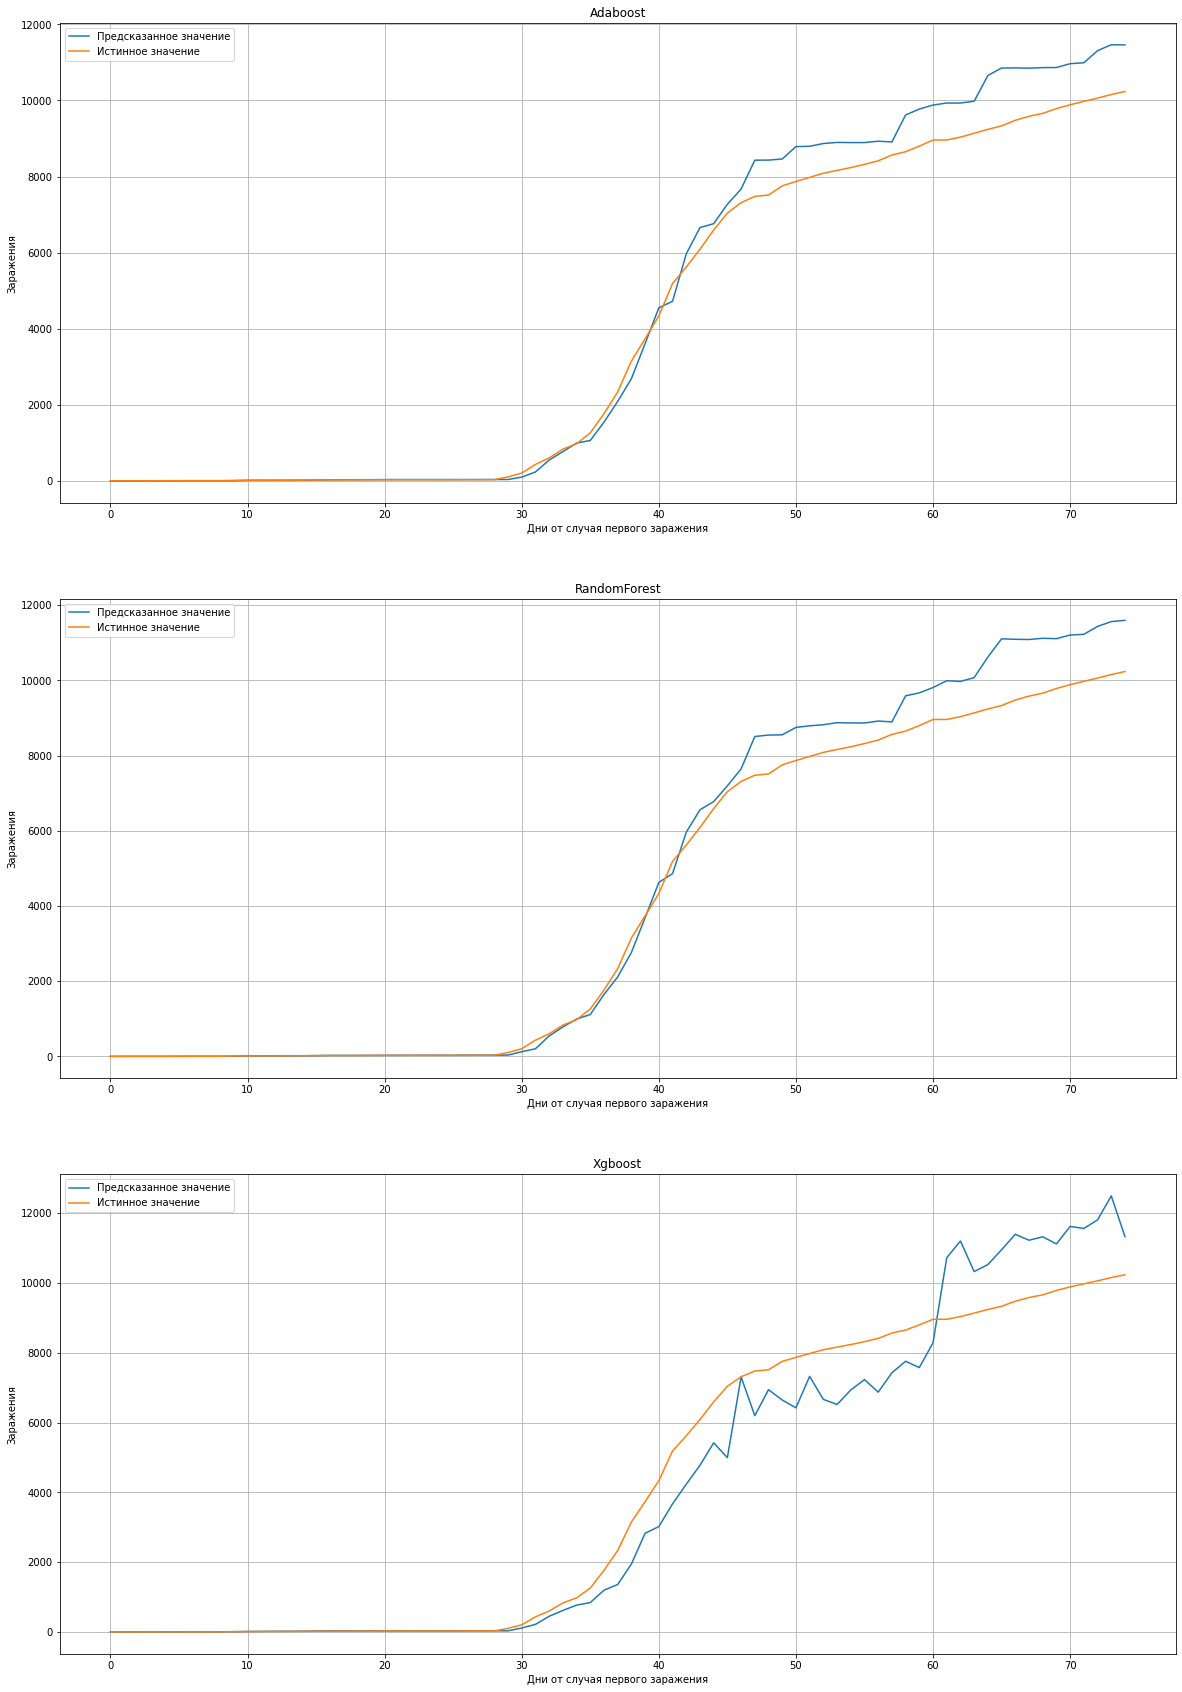

In [0]:
pred_score(model, data_pred, death_bool, plot_type)

#Предсказываем новые данные

In [0]:
Matrix_confirmed

{'Adaboost': countries  Afghanistan  Albania  Algeria  ...  West Bank and Gaza  Zambia  Zimbabwe
 04-05            349.0    361.0   1320.0  ...               237.0    39.0       9.0
 04-06            364.0    403.0   1416.0  ...               252.0    43.0       9.0
 04-07            403.0    454.0   1519.0  ...               274.0    48.0       9.0
 04-08            457.0    493.0   1651.0  ...               284.0    50.0       9.0
 04-09            495.0    520.0   1792.0  ...               285.0    57.0       9.0
 04-10            521.0    547.0   1989.0  ...               285.0    76.0       9.0
 04-11            553.0    580.0   2138.0  ...               285.0    93.0       9.0
 04-12            591.0    648.0   2361.0  ...               285.0    98.0       9.0
 04-13            663.0    713.0   2689.0  ...               285.0    99.0       9.0
 04-14            718.0    749.0   2938.0  ...               285.0    99.0       9.0
 04-15            768.0    818.0   3347.0  ...       

In [0]:
# Сколько дней прогнозируем?
days_prog = 32

Matrix_confirmed,Matrix_Death ={},{}
for model_name in model_Confirmed:
  new_data_list = new_data[new_data.days_mart == days_x]
  labels = new_data_list.countries
  predictions_confirmed = [new_data_list.pred_conf.tolist()]
  predictions_Death = [new_data_list.pred_deaths.tolist()]  
  new_data_list = new_data_list.drop(['ForecastId','confirmed','countries','deaths'], axis='columns')
  for _ in range(days_prog):
    #print(data.iloc[-10:-7,-5:])
    prediction_confirmed = model_Confirmed[model_name].predict(new_data_list)
    prediction_Death = model_Death[model_name].predict(new_data_list)
    if log_labels:
      prediction_Death = 10**prediction_Death - 1
      prediction_confirmed = 10**prediction_confirmed - 1
    bad_confirmed = prediction_confirmed<new_data_list["pred_conf"]
    prediction_confirmed[bad_confirmed] = new_data_list[bad_confirmed]["pred_conf"]+np.round(new_data_list[bad_confirmed]["delta_conf1"]*0.9)
    bad_Death = prediction_Death<new_data_list["pred_deaths"]
    prediction_Death[bad_Death] = new_data_list[bad_Death]["pred_deaths"]+np.round(new_data_list[bad_Death]["delta_deaths1"]*0.9)
    new_data_list["delta_conf2"] = new_data_list["delta_conf1"]
    new_data_list["delta_conf1"] = prediction_confirmed - new_data_list["pred_conf"] 
    new_data_list["pred_conf"] = prediction_confirmed

    new_data_list["delta_deaths2"] = new_data_list["delta_deaths1"]
    new_data_list["delta_deaths1"] = prediction_Death - new_data_list["pred_deaths"] 
    #data[data["delta_conf1"] < 0].loc[:,"delta_conf1"] = 0
    new_data_list["pred_deaths"] = prediction_Death  

    new_data_list[["days_mart", "days"]] += 1

    predictions_Death.append(np.round(prediction_Death))
    predictions_confirmed.append(np.round(prediction_confirmed))
  data_list = pd.date_range('2020-04-'+str(days_x-31), periods = days_prog+1, freq ='d')
  data_list = data_list.strftime('%#m-%#d') 
  Matrix_confirmed[model_name] = pd.DataFrame(predictions_confirmed,columns = labels,index = data_list)
  Matrix_Death[model_name] = pd.DataFrame(predictions_Death,columns = labels,index = data_list)
Matrix_confirmed["Среднее"] = (Matrix_confirmed["Xgboost"] + Matrix_confirmed["RandomForest"] + Matrix_confirmed["Adaboost"])//3
Matrix_Death["Среднее"] = (Matrix_Death["Xgboost"] + Matrix_Death["RandomForest"] + Matrix_Death["Adaboost"])//3

## Функция отображения данных

In [0]:
def plot_new(list_countries, Matrix, Death = False,subplot_x = 2):
  plt.rcParams['figure.figsize'] = [20, len(list_countries)*20/subplot_x**2]
  for i, Country in enumerate(list_countries):
    plt.subplot(len(list_countries)// subplot_x + 1, subplot_x, i+1)
    yyy = data2[(data2.countries == Country)&(data2.confirmed>0)&(data2.days_mart>=days_x - 10)]
    if Death:
      plt.plot(yyy.Date, yyy.deaths, label = "Истинное значение")
      plt.gca().set(xlabel='Дата', ylabel='Смерти')
    else:
      plt.plot(yyy.Date, yyy.confirmed, label = "Истинное значение")
      plt.gca().set(xlabel='Дата', ylabel='Заражения')
    for name in Matrix:
      yyy2 = Matrix[name][[Country]]
      plt.plot(yyy2, label = name)
    plt.title(Country)
    plt.xticks(np.arange(0, (10+days_prog), ((10+days_prog)//14)*subplot_x))
    #plt.yticks(np.linspace(0,10+days_prog,30//subplot_x))
    plt.grid(True)
    plt.legend()

## Настройки

In [0]:
# Создаём список стран
list_countries = countries.index.to_list()[65:70]
#list_countries = []
#list_countries.extend(["RU","FR","IT"])

# Количество графиков в строке
subplot_x = 1

#Строим для заражений, или смертей
death_bool = False 
if death_bool:
  Matrix = Matrix_Death
else:
  Matrix = Matrix_confirmed

## Строим график

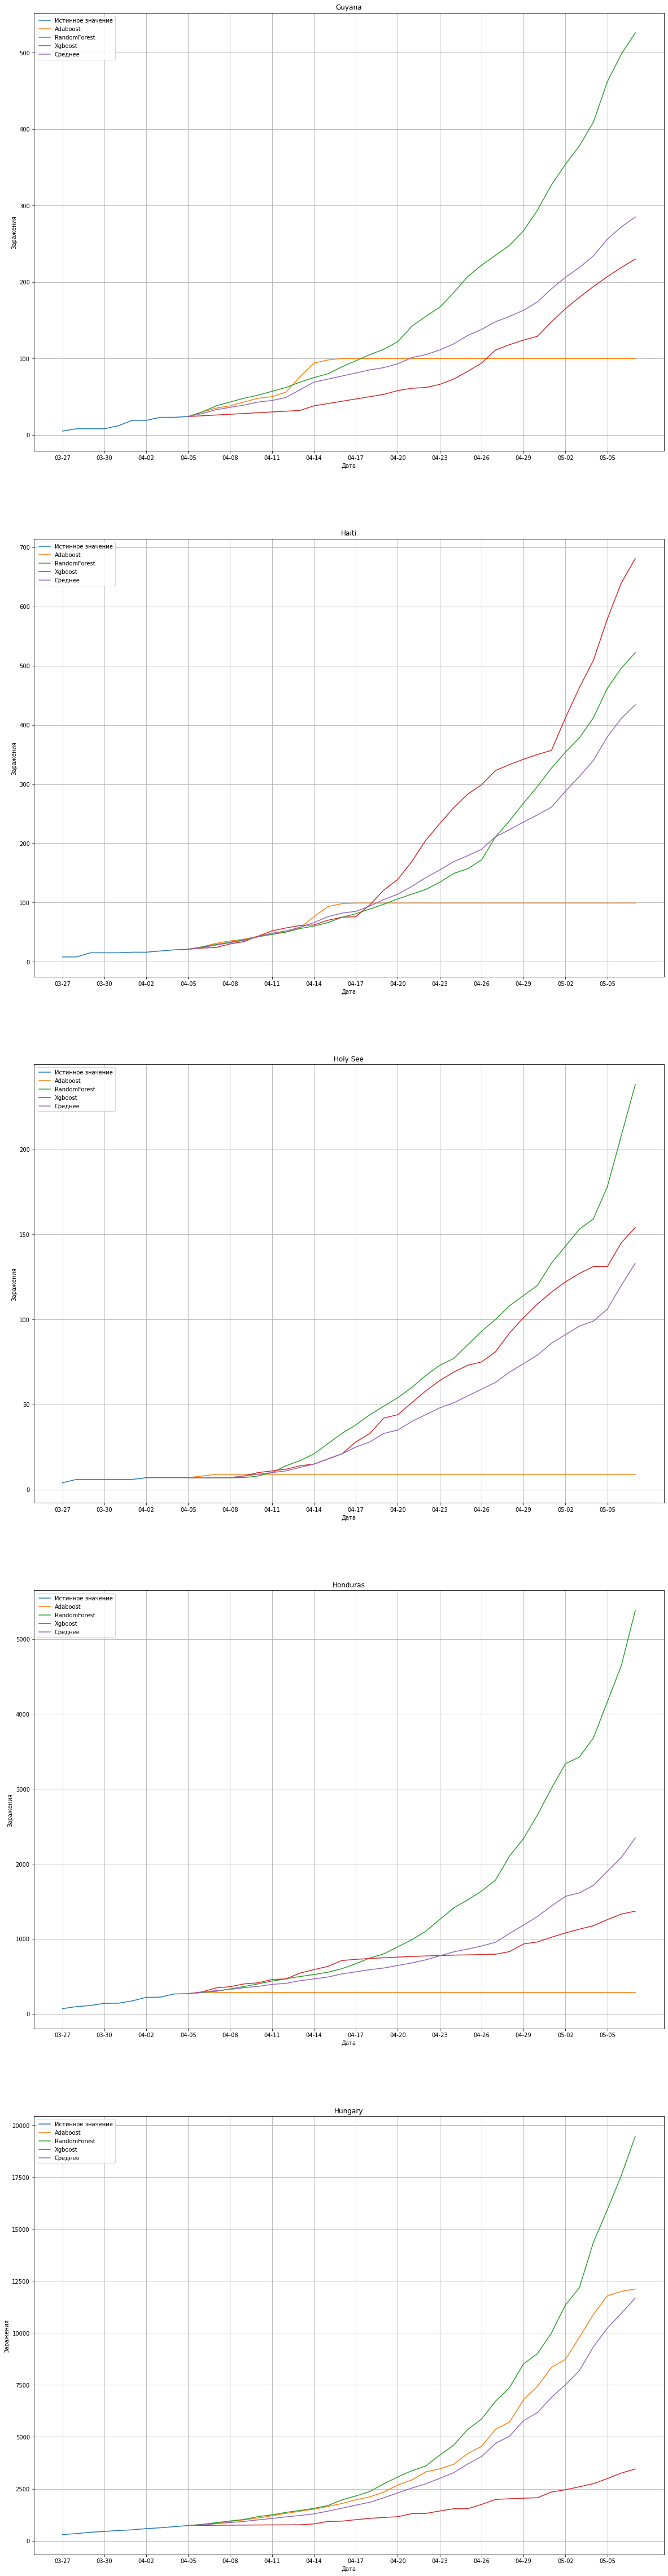

In [0]:
plot_new(list_countries,Matrix,death_bool,subplot_x)

# Сохраняем прогноз

In [243]:
ans = Matrix_confirmed["Среднее"].stack().reset_index()
ans_Death = Matrix_Death["Среднее"].stack().reset_index()
ans["prediction_deaths"] = ans_Death[0]
ans["Province_State"] =  new_data.groupby(["countries", "Province_State"]).max().reset_index()["Province_State"].tolist()*33
ans.columns = ['Date','Country_Region','ConfirmedCases', 'Fatalities',"Province_State"]
ans['Date'] = '2020-'+ans['Date']

train2 = train[(train.Date >= "2020-03-26") & (train.Date < "2020-04-05") ]
train2['Province_State'] = train2['Province_State'].fillna(0)
train2.drop(['Id'], axis='columns',inplace=True)
ans = pd.concat([train2, ans],ignore_index=True)
ans['ConfirmedCases'] = ans['ConfirmedCases'].astype('int')
ans['Fatalities'] = ans['Fatalities'].astype('int')
ans = ans.sort_values(by=['Country_Region','Province_State','Date'])
ans['ForecastId'] = np.arange(1,len(ans)+1)
ans = ans[['ForecastId','ConfirmedCases','Fatalities']]
ans.to_csv('submission.csv', index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
